# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers classical machine learning techniques, namely:
- unsupervised link prediction based on graph-topology (Adamic Adar, Preferential Attachment, Resource-Allocation-Index, ...)
- supervised link prediction using Logistic Regression, Bagging and Boosting

### 1. Import Packages

In [10]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

<module 'util.autoencoder' from 'D:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Machine Learning in Network Science\\3_challenge\\Network-Science_Challenge\\util\\autoencoder.py'>

In [1]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [9]:
# parse & handle data
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# modeling
import torch
from torch_geometric.nn import GAE, VGAE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier

# hyperparameter tuning
from ray import tune, air
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler, MedianStoppingRule, PopulationBasedTraining
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.experiment.trial import Trial
from ray.tune.sklearn import TuneSearchCV

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [32]:
# might take up to a minute
(G, G_train, node_info,
 train_tf, val_tf, trainval_tf,
 test, test_tf,
 X_train, y_train, X_val, y_val, X_trainval, y_trainval,
 X_test) = loadData.load_transform(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected
Enriching train data...
Enriching validation data...
Enriching test data...


In [35]:
# might take up to a minute
data, _ = autoenc.load(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected


In [39]:
# get node embeddings (IF YOU CHANGE SEED = 42, then you need to train new autoencoder as train-val split is different)

# load best autoencoder
path = os.path.abspath("")+"\\models\\autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.5, 5, 0.2, 0.01))
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.trainval_edges)
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

# enrich train
train_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges)).rename(columns = {0: "sim"})
train_tf = (train_tf
    .assign(sim = train_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# enrich val
val_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges)).rename(columns = {0: "sim"})
val_tf = (val_tf
    .assign(sim = val_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# enrich test
test_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.trainval_pos_edges, data.test_edges)).rename(columns = {0: "sim"})
test_tf = (test_tf
    .assign(sim = test_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# split
X_train, y_train = loadData.split_frame(train_tf)
X_val, y_val     = loadData.split_frame(val_tf)
X_test           = loadData.split_frame(test_tf)

# merge to get trainval data
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

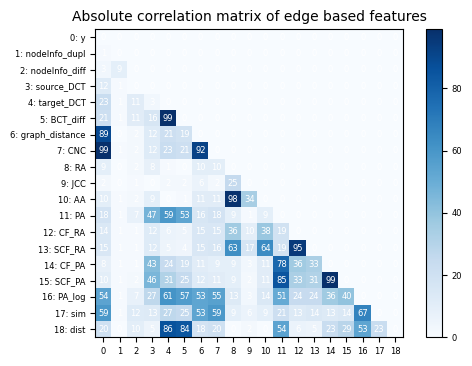

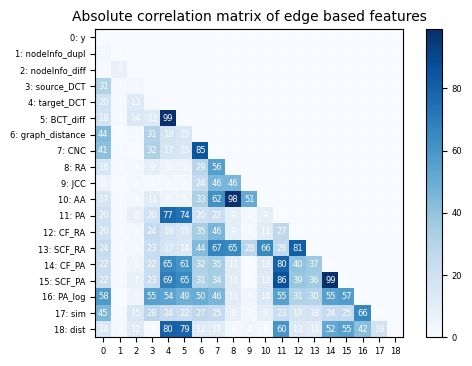

In [7]:
# plot correlation with target (first train, then validation)
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

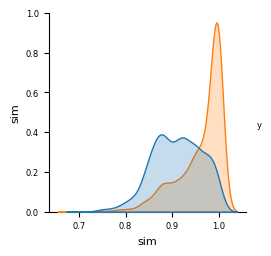

In [8]:
sns.pairplot(val_tf[["sim", "y"]], hue = "y")

### 3. Unsupervised Link Prediction

TODO: try to implement other classical link prediction algos (see lecture 3, Liben-Nowell and Kleinberg Paper in 2003)
- weighted Katz
- Katz clustering
- low-rank inner product
- rooted PageRank
- unseen bigrams
- SimRank
- hitting time

regarding dist: cut off should NOT be mean (only for classical link prediction algos!) --> write a function that finds best cutoff point based on validation set for "sim" and "dist" features that come from autoencoder

In [29]:
# which cols we want to use for link prediction
cols = ["sim", "CNC", "RA", "JCC", "AA", "PA"] # "graph_distance"

# training data
X_train_lp = X_train[cols]
X_train_lp = X_train_lp.rank(pct = True)
#X_train_lp["graph_distance"] = 1 - X_train_lp["graph_distance"] # graph distance: the lower the better!
y_train_hat = (X_train_lp > 0.9).any(axis = 1).astype(int)
y_train_hat.loc[y_train_hat == 0] = (X_train_lp.loc[y_train_hat == 0].mean(axis = 1) > 0.5).astype(int)

# validation data
X_val_lp = X_val[cols]
X_val_lp = X_val_lp.rank(pct = True)
#X_val_lp["graph_distance"] = 1 - X_val_lp["graph_distance"] # graph distance: the lower the better!
y_val_hat = (X_val_lp > 0.9).any(axis = 1).astype(int)
y_val_hat.loc[y_val_hat == 0] = (X_val_lp.loc[y_val_hat == 0].mean(axis = 1) > 0.5).astype(int)

# test data
X_test_lp = X_test[cols]
X_test_lp = X_test_lp.rank(pct = True)
#X_test_lp["graph_distance"] = 1 - X_test_lp["graph_distance"] # graph distance: the lower the better!
y_test_hat = (X_test_lp.mean(axis = 1) > 0.5).astype(int)

In [30]:
# detailed performance analysis
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Validation performance')
print('-------------------------------------------------------')
print(classification_report(y_val, y_val_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_val, y_val_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_val, y_val_hat))

Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4198
           1       0.86      0.86      0.86      4174

    accuracy                           0.86      8372
   macro avg       0.86      0.86      0.86      8372
weighted avg       0.86      0.86      0.86      8372

Validation performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1050
           1       0.80      0.73      0.76      1043

    accuracy                           0.77      2093
   macro avg       0.78      0.77      0.77      2093
weighted avg       0.78      0.77      0.77      2093

Roc_auc score
-------------------------------------------------------
0.7738702460850111

Confusion matrix
-------------------------------------------------------
[[856 194]
 [279 764]]


In [31]:
# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)

In [32]:
# look at predicted labels
save_test.value_counts()

Predicted
0            1799
1            1699
dtype: int64

### 4. Supervised Link Prediction

In [41]:
X_trainval_sv = X_trainval[[col for col in X_trainval.columns if col not in ["CNC", "graph_distance"]]]
X_test_sv  =  X_test[[col for col in X_test.columns  if col not in ["CNC", "graph_distance"]]]

##### a) Logistic Regression

In [50]:
# logistic classifier
clf = LogisticRegressionCV(max_iter=500, random_state=42)
clf.fit(X_trainval, y_trainval)

# predict train
y_trainval_hat = clf.predict(X_trainval)
# compute accuracy
acc_train = accuracy_score(y_trainval, y_trainval_hat)

# print performance
print(f"Acc train: {acc_train}")

Acc train: 0.925370281892021


In [51]:
# predict test
y_test_hat = clf.predict(X_test)

# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)
save_test.value_counts()

##### b) Random Forest & XGBoost

In [54]:
# search spaces
rdForest_params = {
                "n_estimators": tune.randint(10, 500),
                "max_depth": tune.randint(3, 10),
                "min_samples_split": tune.choice([2, 5, 10]),
                "min_samples_leaf": tune.choice([1, 2, 3, 4]),
                "max_features": tune.uniform(0.5, 1),
                "bootstrap": tune.choice([True, False])
            }

XGBoost_params = {
                "n_estimators": tune.randint(10, 500),
                "max_depth": tune.randint(3, 10),
                "min_child_weight": tune.uniform(1, 10),
                "colsample_bytree": tune.uniform(0.5, 1),
                "subsample": tune.uniform(0.6,1),
                "eta": tune.loguniform(1e-3, 1e-1)
            }

# loading models
rdForest_mdl = RandomForestClassifier()
XGBoost_mdl = XGBClassifier()

In [55]:
# tuning RandomForestClassifier with 5-fold cv
tune_search = TuneSearchCV(
    rdForest_mdl,
    rdForest_params,
    search_optimization="hyperopt",
    n_trials=100,
    cv=5,
    early_stopping=False,
    max_iters=1,
    verbose=1
)
tune_search.fit(X_trainval, y_trainval)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_trainval_hat = tune_search.predict(X_trainval)
acc_train = accuracy_score(y_trainval, y_trainval_hat)

print(f"Acc train: {acc_train}")

The TuneSearchCV best hyperparameters : {'n_estimators': 470, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.8060335465395689, 'bootstrap': False}
The TuneSearchCV best score : 0.8910654562828476
Acc train: 0.9346392737697086


In [56]:
# predict test
y_test_hat = tune_search.predict(X_test)

# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)
save_test.value_counts()

Predicted
0            2366
1            1132
dtype: int64

In [57]:
# tuning XGBoostClassifier with 5-fold cv
tune_search = TuneSearchCV(
    XGBoost_mdl,
    XGBoost_params,
    search_optimization="hyperopt",
    n_trials=100,
    cv=5,
    early_stopping=False,
    max_iters=1,
    verbose=1
)
tune_search.fit(X_trainval, y_trainval)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_trainval_hat = tune_search.predict(X_trainval)
acc_train = accuracy_score(y_trainval, y_trainval_hat)

print(f"Acc train: {acc_train}")

The TuneSearchCV best hyperparameters : {'n_estimators': 168, 'max_depth': 5, 'min_child_weight': 4.786364983818028, 'colsample_bytree': 0.9112306547651332, 'subsample': 0.8806396066510646, 'eta': 0.0013587787760379543}
The TuneSearchCV best score : 0.8897276636407071
Acc train: 0.9332059245102723


In [58]:
# predict test
y_test_hat = tune_search.predict(X_test)

# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)
save_test.value_counts()

Predicted
0            2342
1            1156
dtype: int64